# CellRank

[Lange et al., 2022](https://www.nature.com/articles/s41592-021-01346-6)  
[Tutorial](https://cellrank.readthedocs.io/en/stable/index.html)  
[CellRank GitHub](https://github.com/theislab/cellrank)  
[Reproducibility GitHub](https://github.com/theislab/cellrank_reproducibility)  
[Bergen et al., 2021](https://www.embopress.org/doi/full/10.15252/msb.202110282)  

In [ ]:
import scvelo as scv
import scanpy as sc
import cellrank as cr
import numpy as np
import pandas as pd

import os

In [ ]:
# rpy2 
os.environ['R_HOME'] = '/home/fdeckert/bin/miniconda3/envs/p.3.8.12-FD20200109SPLENO/lib/R'

In [ ]:
sc.settings.vector_friendly = False
scv.set_figure_params(figsize=(2, 5))

In [ ]:
os.chdir('/research/peer/fdeckert/FD20200109SPLENO')

In [ ]:
# Plotting 
import rpy2.robjects as robjects
color_load = robjects.r.source('plotting_global.R')
color = dict()
for i in range(len(color_load[0])):
    color[color_load[0].names[i]] = {key : color_load[0][i].rx2(key)[0] for key in color_load[0][i].names}

# Parameter 

In [ ]:
# Input files 
velocyto_h5ad = 'data/object/velocyto.h5ad'

# Output files 
scvelo_h5ad = 'data/object/scvelo_nacl.h5ad'
cellrank_h5ad = 'data/object/cellrank_nacl.h5ad'

# Filter data 
treatment = 'NaCl'
leiden_annotation = ['Meg', 'MEP', 'Ery (1)', 'Ery (2)', 'Ery (3)', 'Ery (4)']

# Transition matrix computation
weight_connectivities=0.2
mode="stochastic" 
n_jobs=8
softmax_scale=None

# Import data 

In [ ]:
adata = sc.read_h5ad(velocyto_h5ad)
obs = pd.read_csv('data/object/adata_sct_hvg2000/meta/meta.csv', index_col=0)
obsm = pd.read_csv('data/object/adata_sct_hvg2000/reductions/X_umap_paga/reduction.csv', index_col=0)

# Filter velocity matrix and combine with obs and obsm from previous analysis. 

In [ ]:
# Filter obs by Ery annotation and treatment 
obs = obs[obs['leiden_annotation'].isin(leiden_annotation)]
obs = obs[obs['treatment']==treatment]

# Filter obsm by cell index
obsm = obsm[obsm.index.isin(obs.index)]

In [ ]:
# Filter velocity adata by obs 
adata = adata[adata.obs.index.isin(obs.index)]

# Order index to match velocity adata 
obs = obs.reindex(adata.obs.index)
obsm = obsm.reindex(adata.obs.index)

adata.obs = obs
adata.obsm['X_umap'] = obsm.to_numpy()

In [ ]:
def set_color(categories): 
    
    categories = [x for x in categories if x in list(adata.obs.columns)]

    for category in categories: 
        
        adata.obs[category] = pd.Series(adata.obs[category], dtype='category')
        
        keys = list(color[category].keys())
        keys = [x for x in keys if x in list(adata.obs[category])]

        adata.obs[category] = adata.obs[category].cat.reorder_categories(keys)
        adata.uns[category+'_colors'] = np.array([color[category].get(key) for key in keys], dtype=object)
        
# Set colors
set_color(list(color.keys()))

In [ ]:
sc.pl.umap(adata, color=['leiden', 'tissue', 'treatment', 'leiden_annotation', 'label_fine_haemosphere', 'sample_rep', 'cc_phase_class', 'pMt_RNA', 'pHb_RNA', 'pRb_RNA'], wspace=1, ncols=5)

# Pre-process

In [ ]:
# filter, normalise, log transform
scv.pp.filter_and_normalize(adata, min_shared_counts=20, log=True, n_top_genes=2000)

# Store log transform data in raw and compute PCA
adata.raw = adata
sc.pp.scale(adata)
sc.pp.pca(adata)
adata.X = adata.raw.X

# compute KNN graph and scvelo's moments
sc.pp.neighbors(adata, n_neighbors=30, use_rep='X_pca')
scv.pp.moments(adata, n_neighbors=None)

# Scvelo

In [ ]:
scv.tl.recover_dynamics(adata)

scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)

scv.tl.latent_time(adata, min_likelihood=0.1)

In [ ]:
scv.set_figure_params(figsize=(2, 5))
scv.pl.velocity_embedding_stream(adata, basis='X_umap', color=['leiden_annotation'])

In [ ]:
sc.pl.umap(adata, color=['root_cells', 'end_points', 'velocity_pseudotime', 'latent_time'])

In [ ]:
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).dropna().index
scv.tl.differential_kinetic_test(adata, var_names=top_genes, groupby='leiden_annotation')

In [ ]:
adata.write_h5ad(scvelo_h5ad)

# CellRank

In [ ]:
from cellrank.tl.estimators import GPCCA

In [ ]:
kernel = cr.tl.transition_matrix(adata, weight_connectivities=weight_connectivities, mode=mode, n_jobs=n_jobs, softmax_scale=softmax_scale)

In [ ]:
g_fwd = GPCCA(kernel)
print(g_fwd)

In [ ]:
# just for consistency, display some summary staes about the transition matrix
T = adata.obsp['T_fwd']
T_med, T_mean, T_var = np.median(T.data), np.mean(T.data), np.var(T.data)
T_min, T_max = np.min(T.data), np.max(T.data)

print(f'med = {T_med:.6f},\nmean = {T_mean:.6f},\nvar = {T_var:.6f},\nmin = {T_min:.6f},\nmax = {T_max:.6f}')

### Compute the real Schur decomposition

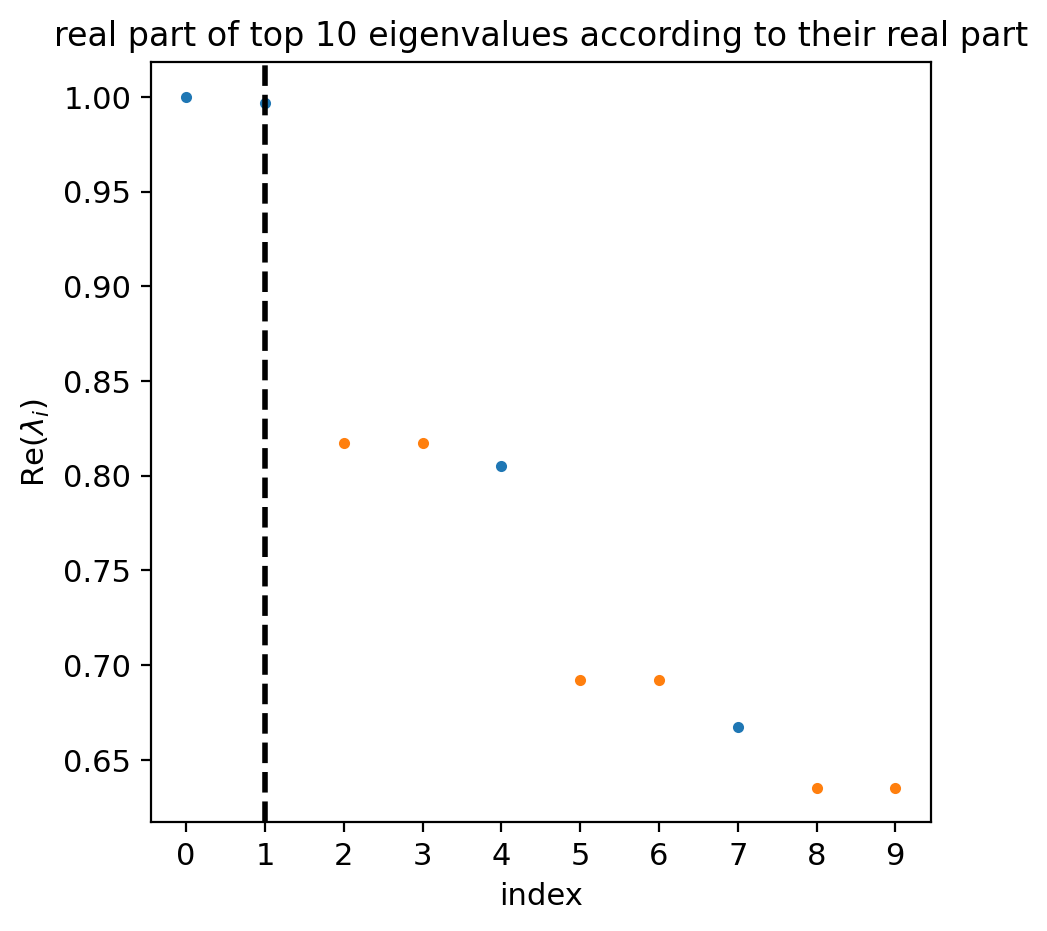

In [106]:
g_fwd.compute_schur()
g_fwd.plot_spectrum(real_only=True)

In [136]:
n_states = 5
g_fwd.compute_macrostates(cluster_key='leiden_annotation', n_states=n_states, n_cells=20)

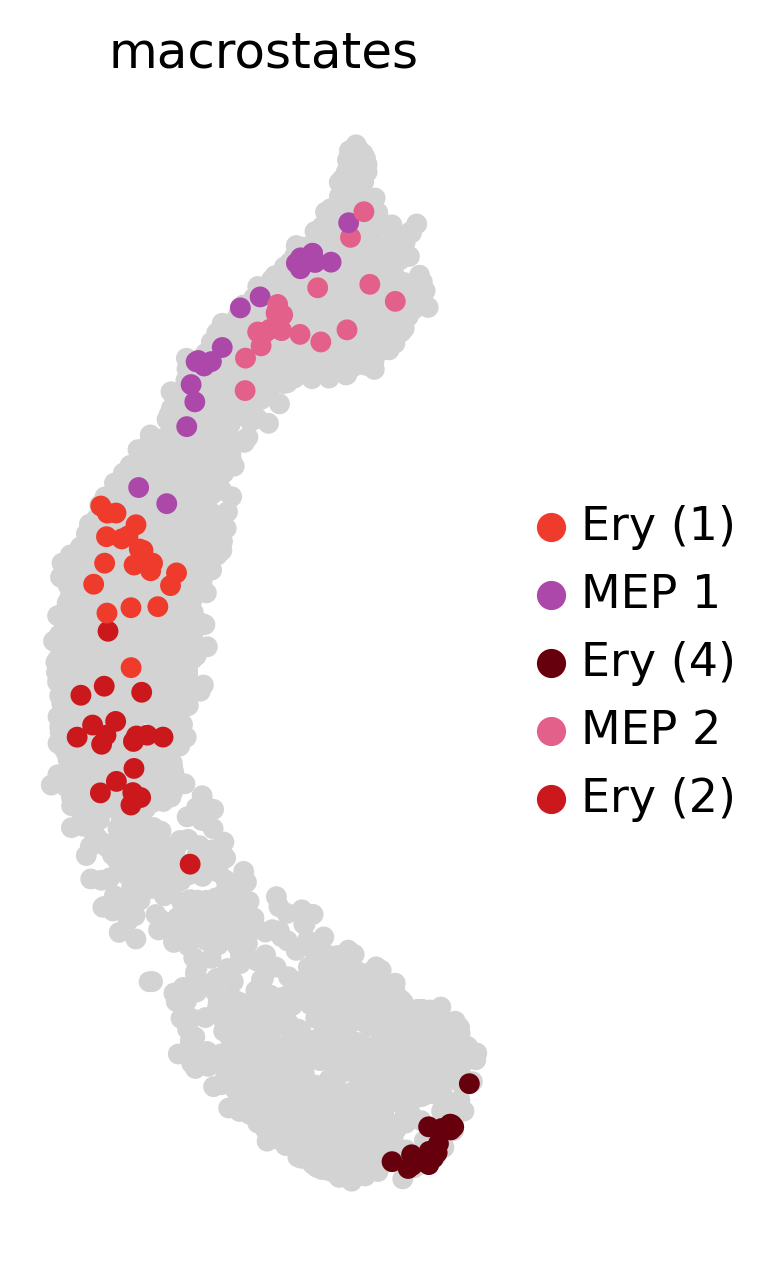

In [137]:
g_fwd.plot_macrostates(legend_loc='right', dpi=150, discrete=True, size=100)

In [138]:
g_fwd.set_terminal_states_from_macrostates()
g_fwd.compute_absorption_probabilities(solver='gmres', n_jobs=n_jobs)

  0%|          | 0/5 [00:00<?, ?/s]

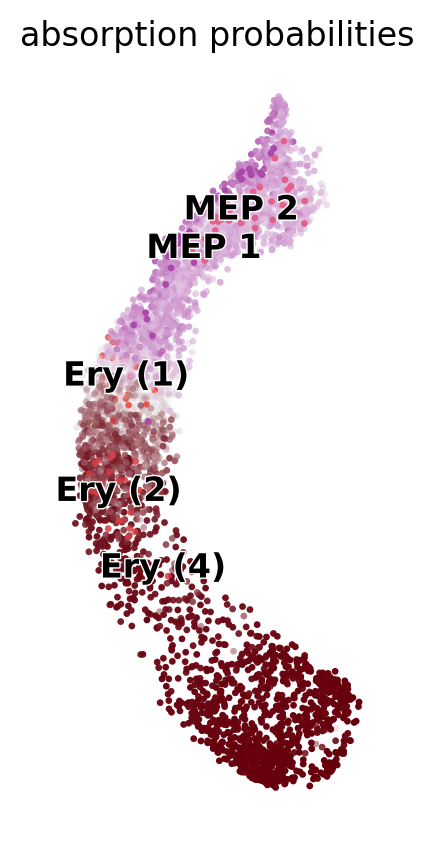

In [139]:
g_fwd.plot_absorption_probabilities()

In [ ]:
GPCCA.write(kernel, 'data/object/g_fwd_nacl', ext='pickle')